In [90]:
import numpy as np
import pandas as pd
from numpy.random import randn

import matplotlib.pyplot as plt
import seaborn as sns
import dataprep as dp
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, LogisticRegression, RANSACRegressor, Ridge, Lasso, ElasticNet


import warnings
warnings.filterwarnings('ignore')

In [91]:
#Import data
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/submission.csv')

train_pp = train
train_ori = train

# EDA

In [92]:
train.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0


+ id : 날짜와 시간별 id
+ hour_bef_temperature : 1시간 전 기온
+ hour_bef_precipitation : 1시간 전 비 정보, 비가 오지 않았으면 0, 비가 오면 1
+ hour_bef_windspeed : 1시간 전 풍속(평균)
+ hour_bef_humidity : 1시간 전 습도
+ hour_bef_visibility : 1시간 전 시정(視程), 시계(視界)(특정 기상 상태에 따른 가시성을 의미)
+ hour_bef_ozone : 1시간 전 오존
+ hour_bef_pm10 : 1시간 전 미세먼지(머리카락 굵기의 1/5에서 1/7 크기의 미세먼지)
+ hour_bef_pm2.5 : 1시간 전 미세먼지(머리카락 굵기의 1/20에서 1/30 크기의 미세먼지)
+ count : 시간에 따른 따릉이 대여 수 

In [93]:
print(train.shape)
print(test.shape)

(1459, 11)
(715, 10)


In [94]:
train.info()
#결측치가 존재. 추후에 1) 결측치 존재하는 record 제거, 2) mean 값으로 채워넣기 중 해야할 듯

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1459 non-null   int64  
 1   hour                    1459 non-null   int64  
 2   hour_bef_temperature    1457 non-null   float64
 3   hour_bef_precipitation  1457 non-null   float64
 4   hour_bef_windspeed      1450 non-null   float64
 5   hour_bef_humidity       1457 non-null   float64
 6   hour_bef_visibility     1457 non-null   float64
 7   hour_bef_ozone          1383 non-null   float64
 8   hour_bef_pm10           1369 non-null   float64
 9   hour_bef_pm2.5          1342 non-null   float64
 10  count                   1459 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 125.5 KB


In [95]:
test.info() # 추후에 훈련 데이터 셋 전처리 기준으로 테스트 데이터를 변환할 계획

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715 entries, 0 to 714
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      715 non-null    int64  
 1   hour                    715 non-null    int64  
 2   hour_bef_temperature    714 non-null    float64
 3   hour_bef_precipitation  714 non-null    float64
 4   hour_bef_windspeed      714 non-null    float64
 5   hour_bef_humidity       714 non-null    float64
 6   hour_bef_visibility     714 non-null    float64
 7   hour_bef_ozone          680 non-null    float64
 8   hour_bef_pm10           678 non-null    float64
 9   hour_bef_pm2.5          679 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 56.0 KB


#### 상관계수
+ r이 -1.0과 -0.7 사이이면, 강한 음적 선형관계,
+ r이 -0.7과 -0.3 사이이면, 뚜렷한 음적 선형관계,
+ r이 -0.3과 -0.1 사이이면, 약한 음적 선형관계,
+ r이 -0.1과 +0.1 사이이면, 거의 무시될 수 있는 선형관계,
+ r이 +0.1과 +0.3 사이이면, 약한 양적 선형관계,
+ r이 +0.3과 +0.7 사이이면, 뚜렷한 양적 선형관계,
+ r이 +0.7과 +1.0 사이이면, 강한 양적 선형관계

따라서 상관계수가 x라고 할 때, -1.0 < x < -0.3 or 0.3 < x < 1.0인 다음의 변수들을 활용하면 될 것 같음:
* hour
* hour_bef_temperature
* hour_bef_windspeed
* hour_bef_humindity
* hour_bef_visibility
* hour_bef_ozone

<AxesSubplot:>

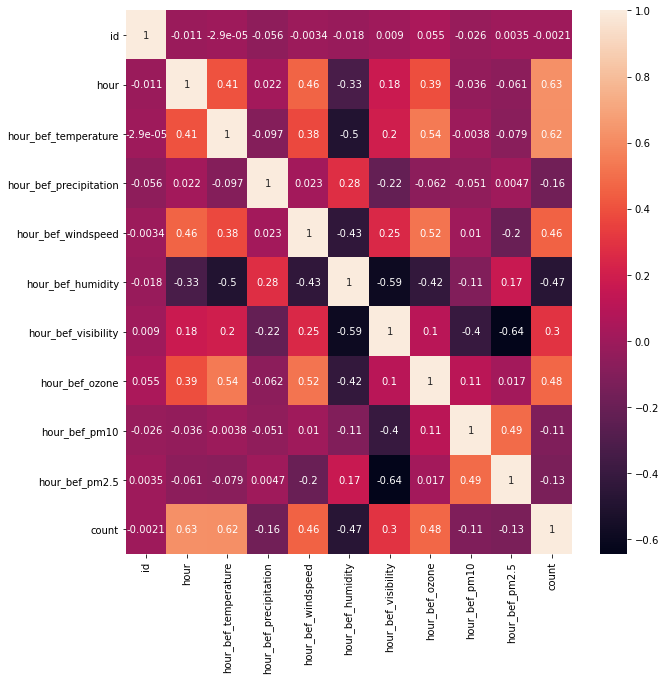

In [96]:
plt.figure(figsize=(10, 10))
sns.heatmap(train.corr(), annot=True)

#### 다중공선성 확인

다중공선성이란 일부 설명 변수가 다른 설명 변수와 상관관계 정도가 높아 회귀 분석시 부정적인 영향을 미치는 현상입니다. 각 독립 변수의 vif (variance inflation factor) 값을 구해서 보통 값이 10 이상이면 다중공선성의 문제가 있다고 판단합니다.

사용할 예정인 6개의 독립변수의 vif 값이 모두 10 이하로 측정되었으니 사용하기로 판단했습니다.

In [97]:
y, X = dmatrices('count ~ hour + hour_bef_temperature + hour_bef_windspeed + hour_bef_humidity + hour_bef_visibility + hour_bef_ozone',
                 train, return_type = 'dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,72.416154,Intercept
1,1.391200,hour
2,1.689949,hour_bef_temperature
3,1.634962,hour_bef_windspeed
4,2.213275,hour_bef_humidity
5,1.648003,hour_bef_visibility
6,1.792794,hour_bef_ozone


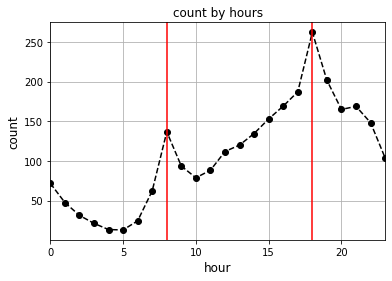

In [98]:
plt.plot(train.groupby('hour').mean()['count'], 'ko--')
plt.grid()

plt.title('count by hours', fontsize=12)
plt.xlabel('hour', fontsize=12)
plt.ylabel('count', fontsize=12)
plt.xlim(0, 23)

plt.axvline(8, color='r')
plt.axvline(18, color='r')

plt.show()

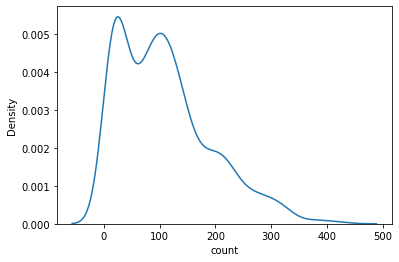

In [99]:
sns.kdeplot(train['count'])
plt.show()

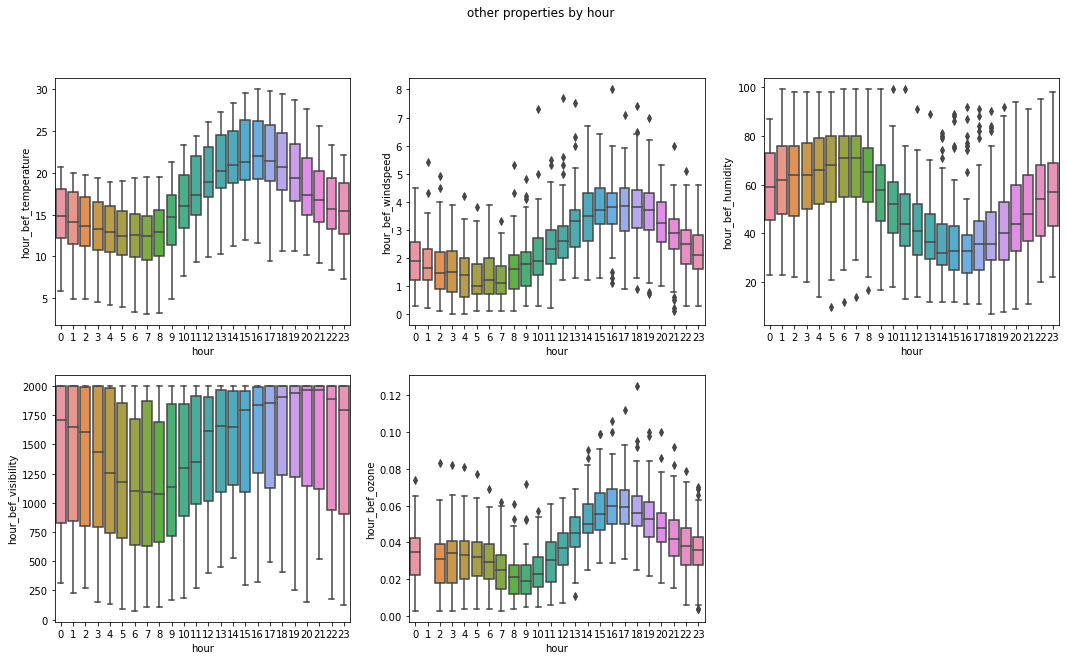

In [100]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

fig.suptitle('other properties by hour')
sns.boxplot(ax=axes[0, 0], data=train, x='hour', y='hour_bef_temperature')
sns.boxplot(ax=axes[0, 1], data=train, x='hour', y='hour_bef_windspeed')
sns.boxplot(ax=axes[0, 2], data=train, x='hour', y='hour_bef_humidity')
sns.boxplot(ax=axes[1, 0], data=train, x='hour', y='hour_bef_visibility')
sns.boxplot(ax=axes[1, 1], data=train, x='hour', y='hour_bef_ozone')
axes[-1, -1].axis('off')

plt.show()

#temperature, winspeed, ozone 합쳐서 하나의 변수로 만들 수 있지않을까

# 전처리

### Filling out missing values

In [101]:
train.isna().sum()

id                          0
hour                        0
hour_bef_temperature        2
hour_bef_precipitation      2
hour_bef_windspeed          9
hour_bef_humidity           2
hour_bef_visibility         2
hour_bef_ozone             76
hour_bef_pm10              90
hour_bef_pm2.5            117
count                       0
dtype: int64

In [102]:
train[train['hour_bef_temperature'].isna()]

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
934,1420,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.0
1035,1553,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [103]:
train.groupby('hour').mean()['hour_bef_temperature']

hour
0     14.788136
1     14.155738
2     13.747541
3     13.357377
4     13.001639
5     12.673770
6     12.377049
7     12.191803
8     12.600000
9     14.318033
10    16.242623
11    18.019672
12    19.457377
13    20.648333
14    21.234426
15    21.744262
16    22.015000
17    21.603333
18    20.926667
19    19.704918
20    18.191803
21    16.978333
22    16.063934
23    15.418033
Name: hour_bef_temperature, dtype: float64

In [104]:
train['hour_bef_temperature'].fillna({934:14.788136, 1035:20.926667}, inplace=True)
train[train['hour_bef_temperature'].isna()]

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count


In [105]:
train[train['hour_bef_windspeed'].isna()].index

Int64Index([18, 244, 260, 376, 780, 934, 1035, 1138, 1229], dtype='int64')

In [106]:
train[train['hour_bef_windspeed'].isna()]

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
18,33,13,22.600000,0.0,NaN,41.0,987.0,0.046,64.0,39.0,208.0
244,381,1,14.100000,0.0,NaN,55.0,1992.0,NaN,NaN,NaN,38.0
260,404,3,14.000000,0.0,NaN,50.0,2000.0,0.049,35.0,22.0,17.0
376,570,0,14.300000,0.0,NaN,49.0,2000.0,0.044,37.0,20.0,58.0
780,1196,20,16.500000,0.0,NaN,31.0,2000.0,0.058,39.0,18.0,181.0
934,1420,0,14.788136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.0
1035,1553,18,20.926667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1138,1717,12,21.400000,0.0,NaN,44.0,1375.0,0.044,61.0,37.0,116.0
1229,1855,2,14.000000,0.0,NaN,52.0,2000.0,0.044,37.0,20.0,20.0


In [107]:
train.groupby('hour').mean()['hour_bef_windspeed']

hour
0     1.965517
1     1.836667
2     1.633333
3     1.620000
4     1.409836
5     1.296721
6     1.331148
7     1.262295
8     1.632787
9     1.829508
10    2.122951
11    2.485246
12    2.766667
13    3.281356
14    3.522951
15    3.768852
16    3.820000
17    3.801667
18    3.838333
19    3.595082
20    3.278333
21    2.755000
22    2.498361
23    2.195082
Name: hour_bef_windspeed, dtype: float64

In [108]:
train['hour_bef_windspeed'].fillna({18: 3.281356, 244: 1.836667, 260: 1.620000, 376: 1.965517, 780: 3.278333, 934: 1.965517, 1035: 3.838333, 1138: 2.766667, 1229: 1.633333}, inplace=True)
train[train['hour_bef_windspeed'].isna()]

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count


In [109]:
#결측치 insert function
def fill_nan(dat, atts):
    for att in atts:
        fill_dict = {}
        idxs = dat[dat[att].isna()].index
        att_by_hr = dat.groupby('hour').mean()[att]
        for idx in idxs:
            hr_mean = att_by_hr[dat['hour'][idx]]
            fill_dict[idx] = hr_mean
        dat[att].fillna(fill_dict, inplace=True)

In [110]:
fill_nan(train, ['hour_bef_humidity'])

In [111]:
train[train['hour_bef_humidity'].isna()]

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count


In [112]:
train.groupby('hour').mean()['hour_bef_ozone']

hour
0     0.033763
1          NaN
2     0.030492
3     0.031213
4     0.031984
5     0.031623
6     0.029317
7     0.025300
8     0.021197
9     0.021492
10    0.025167
11    0.030367
12    0.036817
13    0.045203
14    0.053344
15    0.057400
16    0.060579
17    0.060362
18    0.058508
19    0.053967
20    0.048279
21    0.043517
22    0.038066
23    0.035148
Name: hour_bef_ozone, dtype: float64

In [113]:
fill_nan(train, ['hour_bef_humidity'])

#ozone은 1시 데이터가 전부 결측치라서 전시간과 후시간 평균을 더한 후 2로 나눠서 그 사이값을 입력
fill_dict = {}
idxs = train[train['hour_bef_ozone'].isna()].index
att_by_hr = train.groupby('hour').mean()['hour_bef_ozone']
for idx in idxs:
    hr_mean = att_by_hr[train['hour'][idx]]
    fill_dict[idx] = hr_mean
    if train['hour'][idx] == 1:
        fill_dict[idx] = (0.033763 + 0.030492) / 2
train['hour_bef_ozone'].fillna(fill_dict, inplace=True)

### Deleting outliers

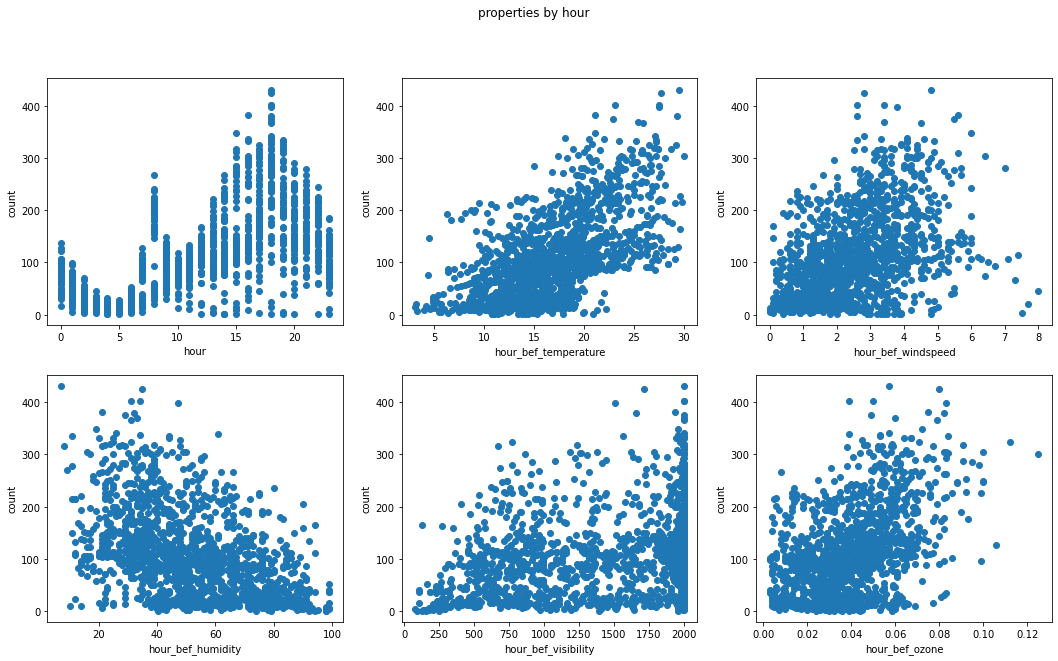

In [114]:
columns = ['hour', 'hour_bef_temperature', 'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility', 'hour_bef_ozone']
axis_ = [[0,0], [0,1], [0,2], [1,0], [1,1], [1,2]]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

fig.suptitle('properties by hour')

i = 0
for axis in axis_:
    axes[axis[0], axis[1]].scatter(train_pp[columns[i]], train_pp['count'])
    axes[axis[0], axis[1]].set_xlabel(columns[i])
    axes[axis[0], axis[1]].set_ylabel('count')
    i+=1

plt.show()

In [115]:
col_name=['hour', 'hour_bef_temperature', 'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility', 'hour_bef_ozone']

for ilt in col_name:
    Q1=train[ilt].quantile(0.25)
    Q3=train[ilt].quantile(0.75)
    IQR=Q3-Q1
    train_delout=train_pp[(train_pp[ilt]<(Q1 - 1.5*IQR)) | (train_pp[ilt]>(Q3+1.5*IQR))]
    train_pp=train_pp.drop(train_delout.index, axis=0)
train_pp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1435 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1435 non-null   int64  
 1   hour                    1435 non-null   int64  
 2   hour_bef_temperature    1435 non-null   float64
 3   hour_bef_precipitation  1433 non-null   float64
 4   hour_bef_windspeed      1435 non-null   float64
 5   hour_bef_humidity       1435 non-null   float64
 6   hour_bef_visibility     1433 non-null   float64
 7   hour_bef_ozone          1435 non-null   float64
 8   hour_bef_pm10           1347 non-null   float64
 9   hour_bef_pm2.5          1320 non-null   float64
 10  count                   1435 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 134.5 KB


In [116]:
fill_nan(train_pp, ['hour_bef_temperature', 'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility'])

fill_dict = {}
idxs = train_pp[train_pp['hour_bef_ozone'].isna()].index
att_by_hr = train_pp.groupby('hour').mean()['hour_bef_ozone']
for idx in idxs:
    hr_mean = att_by_hr[train['hour'][idx]]
    fill_dict[idx] = hr_mean
    if train_pp['hour'][idx] == 1:
        fill_dict[idx] = (0.033763 + 0.030492) / 2
train_pp['hour_bef_ozone'].fillna(fill_dict, inplace=True)

train_pp[['hour', 'hour_bef_temperature', 'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility', 'hour_bef_ozone']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1435 entries, 0 to 1458
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   hour                  1435 non-null   int64  
 1   hour_bef_temperature  1435 non-null   float64
 2   hour_bef_windspeed    1435 non-null   float64
 3   hour_bef_humidity     1435 non-null   float64
 4   hour_bef_visibility   1435 non-null   float64
 5   hour_bef_ozone        1435 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 118.5 KB


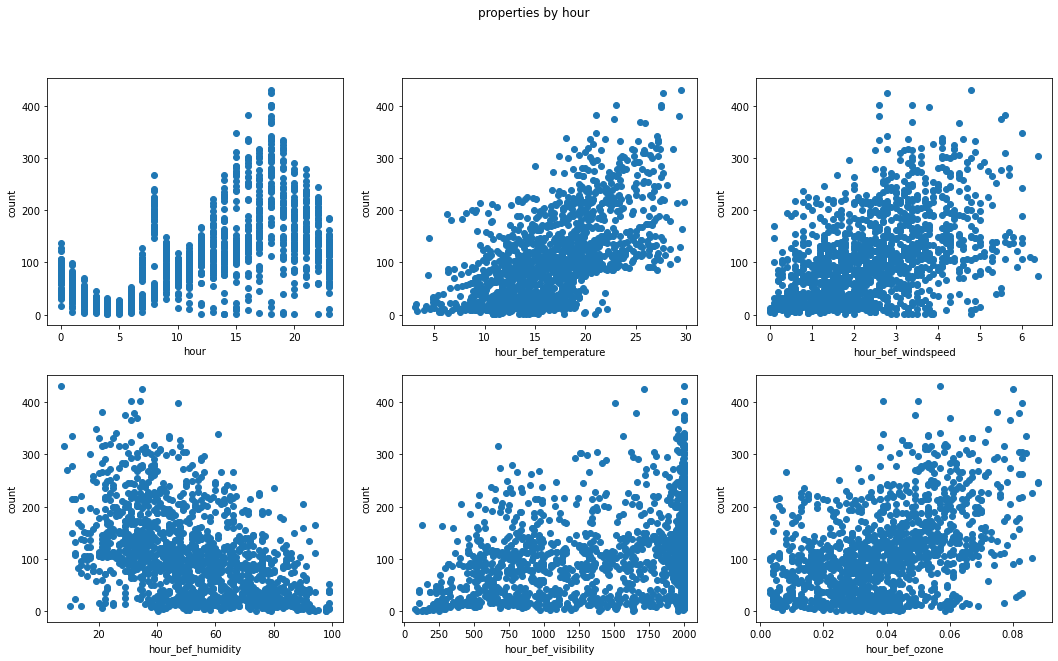

In [117]:
axis_ = [[0,0], [0,1], [0,2], [1,0], [1,1], [1,2]]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

fig.suptitle('properties by hour')

i = 0
for axis in axis_:
    axes[axis[0], axis[1]].scatter(train_pp[columns[i]], train_pp['count'])
    axes[axis[0], axis[1]].set_xlabel(columns[i])
    axes[axis[0], axis[1]].set_ylabel('count')
    i+=1

plt.show()

# Modeling

In [118]:
#Graph Drawer
def draw_graph(name_, y_pred, y_test):
    df = pd.DataFrame({'prediction': y_pred, 'actual': y_test})
    df = df.sort_values(by='actual').reset_index(drop=True)
    
    plt.figure(figsize=(11, 8))
    plt.scatter(df.index, df['prediction'], marker='x', color='r')
    plt.scatter(df.index, df['actual'], alpha=0.7, marker='o', color='black')
    plt.xlabel('index', fontsize=20)
    plt.ylabel('count', fontsize=20)
    plt.title(name_, fontsize=15)
    plt.legend(['prediction', 'actual'], fontsize=12)
    plt.show()

In [119]:
train_del=train_ori.dropna(axis=0)
train_ins=train

train_ins.info()
train_del.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1459 non-null   int64  
 1   hour                    1459 non-null   int64  
 2   hour_bef_temperature    1459 non-null   float64
 3   hour_bef_precipitation  1457 non-null   float64
 4   hour_bef_windspeed      1459 non-null   float64
 5   hour_bef_humidity       1459 non-null   float64
 6   hour_bef_visibility     1457 non-null   float64
 7   hour_bef_ozone          1459 non-null   float64
 8   hour_bef_pm10           1369 non-null   float64
 9   hour_bef_pm2.5          1342 non-null   float64
 10  count                   1459 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 125.5 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1341 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column                  Non-Null Count  

In [120]:
#Train Test Split
columns = ['hour', 'hour_bef_temperature', 'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility', 'hour_bef_ozone']

#세개의 데이터 셋 준비:
# 1. 결측치 제거 버전 (_del)
# 2. 결측치 시간별 평균으로 채운 버전 (_ins)
# 3. 결측치 시간별 평균으로 채우고 이상치 제거한 버전 (_deloutlier)

X = train_del[columns]
y = train_del[['count']]
X_train_del, X_test_del, y_train_del, y_test_del = train_test_split(X, y, test_size=0.33, random_state=2021)

X = train_ins[columns]
y = train_ins[['count']]
X_train_ins, X_test_ins, y_train_ins, y_test_ins = train_test_split(X, y, test_size=0.33, random_state=2021)

X = train_pp[columns]
y = train_pp[['count']]
X_train_deloutlier, X_test_deloutlier, y_train_deloutlier, y_test_deloutlier = train_test_split(X, y, test_size=0.33, random_state=2021)

# 정규화 툴
scaler = StandardScaler()

### 사용할 수 있는 모델 (Regression Models):
1. Linear Regression
2. Linear + RANSAC Regressor
3. Ridge
4. Lasso
5. ElasticNet 
6. Decision Tree
7. Ensemble

In [121]:
#파이프라인 툴 생성
pipe_Linear = Pipeline([('scaler', scaler),
           ('reg', LinearRegression())])

pipe_Logistic = Pipeline([('scaler', scaler),
           ('reg', LogisticRegression())])

pipe_RANSAC = Pipeline([('scaler', scaler),
           ('reg', RANSACRegressor())])

pipe_Ridge = Pipeline([('scaler', scaler),
           ('reg', Ridge())])

pipe_Lasso = Pipeline([('scaler', scaler),
           ('reg', Lasso())])

pipe_ElasticNet = Pipeline([('scaler', scaler),
           ('reg', ElasticNet())])

pipe_DecisionTree = Pipeline([('scaler', scaler),
           ('reg', LinearRegression())])

pipe_Ensemble = Pipeline([('scaler', scaler),
           ('reg', LinearRegression())])


kfold = KFold(n_splits=4, shuffle=True, random_state=2021) #inner fold
outer_kfold = KFold(n_splits=5, shuffle=True, random_state=2021)

#### Linear Regression

In [122]:
scores_ins = cross_val_score(pipe_Linear, X_train_ins, y_train_ins, scoring='neg_mean_squared_error', cv=kfold, n_jobs=-1)
print('Data insert 방식을 사용한 경우 점수: ', scores_ins)
print('평균점수: ', scores_ins.mean())

scores_del = cross_val_score(pipe_Linear, X_train_del, y_train_del, scoring='neg_mean_squared_error', cv=kfold, n_jobs=-1)
print('Data insert 방식을 사용한 경우 점수: ', scores_del)
print('평균점수: ', scores_del.mean())

Data insert 방식을 사용한 경우 점수:  [nan nan nan nan]
평균점수:  nan
Data insert 방식을 사용한 경우 점수:  [-2832.21399301 -3245.93120668 -2763.83504707 -3116.13785281]
평균점수:  -2989.52952489155


#### Logistic Regression

In [123]:
#Classifier로 쓰는건가?? 오류가 큼
params = {"reg__C": [0.0001, 0.001, 0.01, 0.1, 1.0]}
gs_logistic = GridSearchCV(pipe_Logistic, params, cv=kfold, n_jobs=-1)

scores_ins = cross_val_score(gs_logistic, X_train_ins, y_train_ins, scoring='neg_mean_squared_error', cv=outer_kfold, n_jobs=-1)
print('Data insert 방식을 사용한 경우 점수: ', scores_ins)
print('평균점수: ', scores_ins.mean())

scores_del = cross_val_score(gs_logistic, X_train_del, y_train_del, scoring='neg_mean_squared_error', cv=outer_kfold, n_jobs=-1)
print('Data insert 방식을 사용한 경우 점수: ', scores_del)
print('평균점수: ', scores_del.mean())

Data insert 방식을 사용한 경우 점수:  [nan nan nan nan nan]
평균점수:  nan
Data insert 방식을 사용한 경우 점수:  [-4943.73888889 -5163.48333333 -6260.58333333 -4123.93854749
 -6376.22905028]
평균점수:  -5373.594630664184


#### Linear Regression + RANSAC

In [124]:
pipe_RANSAC.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()), ('reg', RANSACRegressor())],
 'verbose': False,
 'scaler': StandardScaler(),
 'reg': RANSACRegressor(),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'reg__base_estimator': None,
 'reg__is_data_valid': None,
 'reg__is_model_valid': None,
 'reg__loss': 'absolute_loss',
 'reg__max_skips': inf,
 'reg__max_trials': 100,
 'reg__min_samples': None,
 'reg__random_state': None,
 'reg__residual_threshold': None,
 'reg__stop_n_inliers': inf,
 'reg__stop_probability': 0.99,
 'reg__stop_score': inf}

In [125]:
outer_kfold = KFold(n_splits=5, shuffle=True, random_state=2021)

RANSAC_params = {"reg__max_trials": [10, 50, 100, 500, 1000],
         "reg__min_samples": [None, 1, 3, 10]}
gs_RANSAC = GridSearchCV(pipe_RANSAC, RANSAC_params, cv=kfold, n_jobs=-1)

scores_ins = cross_val_score(gs_RANSAC, X_train_ins, y_train_ins, scoring='neg_mean_squared_error', cv=outer_kfold, n_jobs=-1)
print('Data insert 방식을 사용한 경우 점수: ', scores_ins)
print('평균점수: ', scores_ins.mean())

scores_del = cross_val_score(gs_RANSAC, X_train_del, y_train_del, scoring='neg_mean_squared_error', cv=outer_kfold, n_jobs=-1)
print('Data insert 방식을 사용한 경우 점수: ', scores_del)
print('평균점수: ', scores_del.mean())

Data insert 방식을 사용한 경우 점수:  [nan nan nan nan nan]
평균점수:  nan
Data insert 방식을 사용한 경우 점수:  [-3039.67954904 -3783.34023633 -3756.39169079 -2689.33621502
 -3381.35776768]
평균점수:  -3330.021091769988


#### Logistic Regression + Ridge

In [126]:
pipe_Ridge.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()), ('reg', Ridge())],
 'verbose': False,
 'scaler': StandardScaler(),
 'reg': Ridge(),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'reg__alpha': 1.0,
 'reg__copy_X': True,
 'reg__fit_intercept': True,
 'reg__max_iter': None,
 'reg__normalize': False,
 'reg__random_state': None,
 'reg__solver': 'auto',
 'reg__tol': 0.001}

In [127]:
Ridge_params = {"reg__alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
gs_Ridge = GridSearchCV(pipe_Ridge, Ridge_params, cv=kfold, n_jobs=-1)

scores_ins = cross_val_score(gs_Ridge, X_train_ins, y_train_ins, scoring='neg_mean_squared_error', cv=outer_kfold, n_jobs=-1)
print('Data insert 방식을 사용한 경우 점수: ', scores_ins)
print('평균점수: ', scores_ins.mean())

scores_del = cross_val_score(gs_Ridge, X_train_del, y_train_del, scoring='neg_mean_squared_error', cv=outer_kfold, n_jobs=-1)
print('Data insert 방식을 사용한 경우 점수: ', scores_del)
print('평균점수: ', scores_del.mean())

Data insert 방식을 사용한 경우 점수:  [nan nan nan nan nan]
평균점수:  nan
Data insert 방식을 사용한 경우 점수:  [-2768.43796394 -3323.70000098 -3163.74466222 -2630.12736947
 -3082.61987963]
평균점수:  -2993.7259752480372


#### Logistic Regression + Lasso

In [128]:
Lasso_params = {"reg__alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
gs_Lasso = GridSearchCV(pipe_Lasso, Lasso_params, cv=kfold, n_jobs=-1)

scores_ins = cross_val_score(gs_Lasso, X_train_ins, y_train_ins, scoring='neg_mean_squared_error', cv=outer_kfold, n_jobs=-1)
print('Data insert 방식을 사용한 경우 점수: ', scores_ins)
print('평균점수: ', scores_ins.mean())

scores_del = cross_val_score(gs_Lasso, X_train_del, y_train_del, scoring='neg_mean_squared_error', cv=outer_kfold, n_jobs=-1)
print('Data insert 방식을 사용한 경우 점수: ', scores_del)
print('평균점수: ', scores_del.mean())

Data insert 방식을 사용한 경우 점수:  [nan nan nan nan nan]
평균점수:  nan
Data insert 방식을 사용한 경우 점수:  [-2769.85766091 -3321.27959969 -3172.95482947 -2630.82700479
 -3082.54051346]
평균점수:  -2995.491921664165


#### Logistic Regression + Lasso

In [129]:
pipe_ElasticNet.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()), ('reg', ElasticNet())],
 'verbose': False,
 'scaler': StandardScaler(),
 'reg': ElasticNet(),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'reg__alpha': 1.0,
 'reg__copy_X': True,
 'reg__fit_intercept': True,
 'reg__l1_ratio': 0.5,
 'reg__max_iter': 1000,
 'reg__normalize': False,
 'reg__positive': False,
 'reg__precompute': False,
 'reg__random_state': None,
 'reg__selection': 'cyclic',
 'reg__tol': 0.0001,
 'reg__warm_start': False}

In [130]:
ElasticNet_params = {"reg__alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                    "reg__l1_ratio": [0, 0.25, 0.5, 0.75, 1]}
gs_ElasticNet = GridSearchCV(pipe_ElasticNet, ElasticNet_params, cv=kfold, n_jobs=-1)

scores_ins = cross_val_score(gs_ElasticNet, X_train_ins, y_train_ins, scoring='neg_mean_squared_error', cv=outer_kfold, n_jobs=-1)
print('Data insert 방식을 사용한 경우 점수: ', scores_ins)
print('평균점수: ', scores_ins.mean())

scores_del = cross_val_score(gs_ElasticNet, X_train_del, y_train_del, scoring='neg_mean_squared_error', cv=outer_kfold, n_jobs=-1)
print('Data insert 방식을 사용한 경우 점수: ', scores_del)
print('평균점수: ', scores_del.mean())

Data insert 방식을 사용한 경우 점수:  [nan nan nan nan nan]
평균점수:  nan
Data insert 방식을 사용한 경우 점수:  [-2762.83704649 -3333.32385255 -3158.65367007 -2633.60740465
 -3083.63865007]
평균점수:  -2994.4121247662542


#### Linear Regression

xgboost lgram
knn mice
noise 처리
automl
